## 1. 데이터 준비하기

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


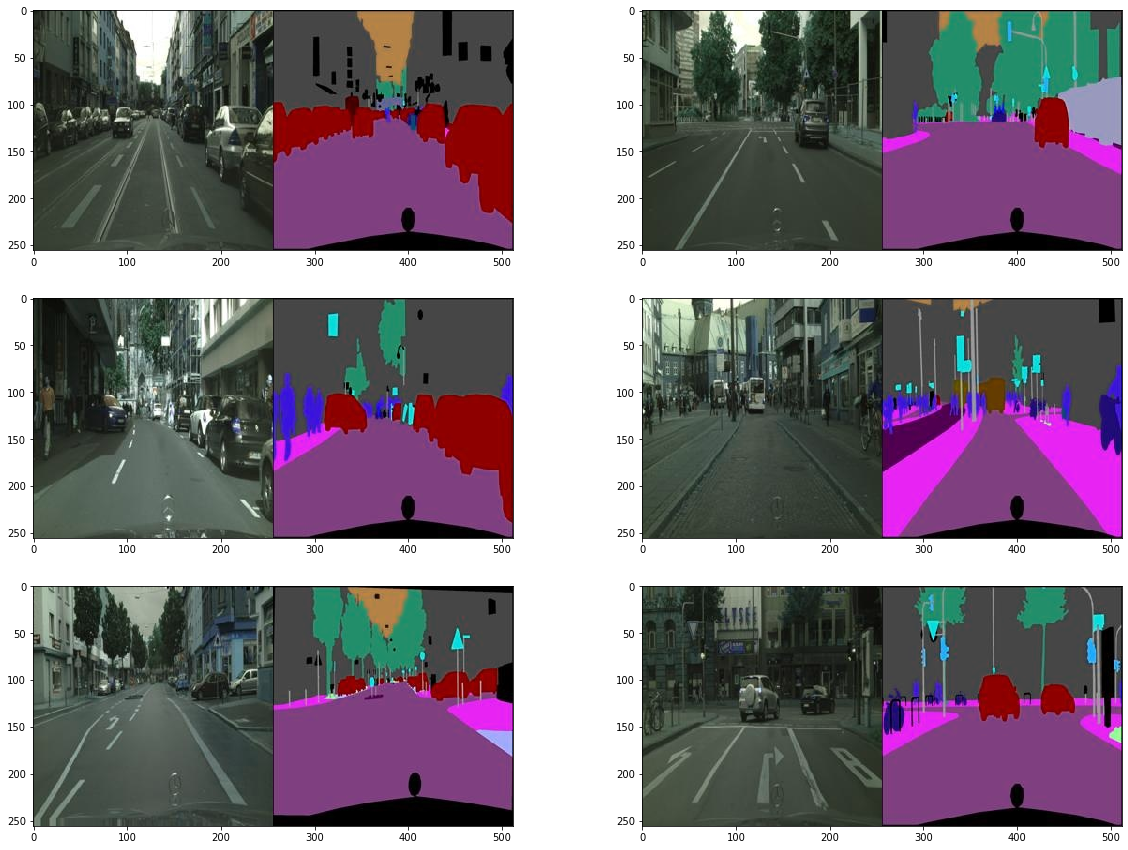

In [2]:
# 임의로 6장을 선택해 시각화
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
#이미지의 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


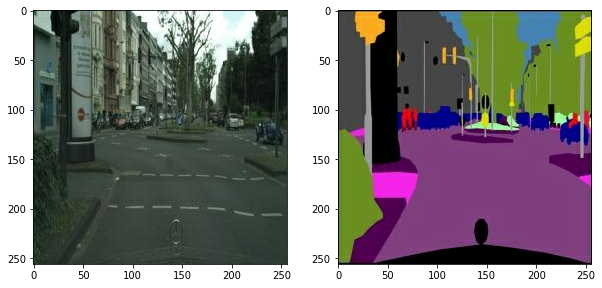

In [4]:
# (256, 512, 3) -> (256,256,3) * 2로 이미지 분할
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [5]:
# 학습에 사용하는 데이터의 다양성을 높이기 위해 argumentation 적용
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


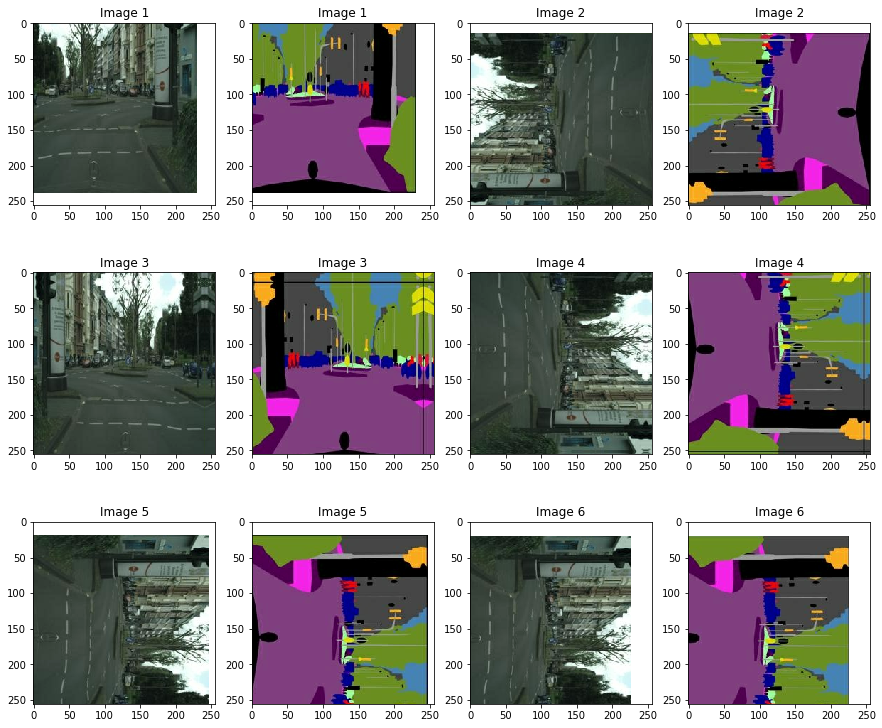

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

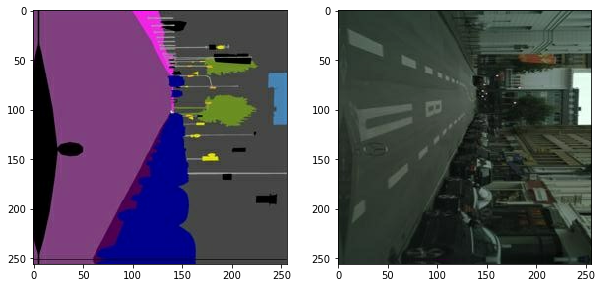

In [7]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return  colored, sketch

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 2.Generator 구성하기

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [9]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [10]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [11]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [12]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [13]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## 3. Generator 재구성

In [14]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [15]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [16]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

## 4. Discriminator 구성

In [17]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [18]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [19]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [20]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

## 5. 학습 및 테스트

In [21]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [22]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [23]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [24]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8391                     
L1_loss:0.2953                     
Discriminator_loss:1.2829

EPOCH[1] - STEP[20]                     
Generator_loss:1.0972                     
L1_loss:0.2154                     
Discriminator_loss:1.2565

EPOCH[1] - STEP[30]                     
Generator_loss:0.8757                     
L1_loss:0.2508                     
Discriminator_loss:1.3713

EPOCH[1] - STEP[40]                     
Generator_loss:0.8681                     
L1_loss:0.1868                     
Discriminator_loss:1.1962

EPOCH[1] - STEP[50]                     
Generator_loss:0.7775                     
L1_loss:0.1758                     
Discriminator_loss:1.3582

EPOCH[1] - STEP[60]                     
Generator_loss:0.7642                     
L1_loss:0.1948                     
Discriminator_loss:1.2224

EPOCH[1] - STEP[70]                     
Generator_loss:1.2545                     
L1_loss:0.2061                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.9496                     
L1_loss:0.1685                     
Discriminator_loss:0.7275

EPOCH[3] - STEP[80]                     
Generator_loss:2.4137                     
L1_loss:0.2034                     
Discriminator_loss:0.7864

EPOCH[3] - STEP[90]                     
Generator_loss:1.4818                     
L1_loss:0.1870                     
Discriminator_loss:0.4432

EPOCH[3] - STEP[100]                     
Generator_loss:2.6198                     
L1_loss:0.1564                     
Discriminator_loss:1.3427

EPOCH[3] - STEP[110]                     
Generator_loss:1.4759                     
L1_loss:0.1690                     
Discriminator_loss:0.5181

EPOCH[3] - STEP[120]                     
Generator_loss:0.9570                     
L1_loss:0.1979                     
Discriminator_loss:0.6808

EPOCH[3] - STEP[130]                     
Generator_loss:0.9248                     
L1_loss:0.2041                

EPOCH[5] - STEP[130]                     
Generator_loss:0.9098                     
L1_loss:0.1677                     
Discriminator_loss:2.0294

EPOCH[5] - STEP[140]                     
Generator_loss:1.6825                     
L1_loss:0.1779                     
Discriminator_loss:0.5163

EPOCH[5] - STEP[150]                     
Generator_loss:1.5053                     
L1_loss:0.1481                     
Discriminator_loss:0.9561

EPOCH[5] - STEP[160]                     
Generator_loss:0.8696                     
L1_loss:0.1979                     
Discriminator_loss:0.7389

EPOCH[5] - STEP[170]                     
Generator_loss:1.7627                     
L1_loss:0.1397                     
Discriminator_loss:1.5559

EPOCH[5] - STEP[180]                     
Generator_loss:1.6722                     
L1_loss:0.1542                     
Discriminator_loss:0.9380

EPOCH[5] - STEP[190]                     
Generator_loss:1.0485                     
L1_loss:0.1896             

EPOCH[7] - STEP[190]                     
Generator_loss:1.2194                     
L1_loss:0.1599                     
Discriminator_loss:1.1204

EPOCH[7] - STEP[200]                     
Generator_loss:1.0923                     
L1_loss:0.1583                     
Discriminator_loss:0.7296

EPOCH[7] - STEP[210]                     
Generator_loss:2.0583                     
L1_loss:0.2009                     
Discriminator_loss:1.4265

EPOCH[7] - STEP[220]                     
Generator_loss:0.6943                     
L1_loss:0.1953                     
Discriminator_loss:1.0274

EPOCH[7] - STEP[230]                     
Generator_loss:0.9668                     
L1_loss:0.1836                     
Discriminator_loss:1.6701

EPOCH[7] - STEP[240]                     
Generator_loss:1.6880                     
L1_loss:0.1650                     
Discriminator_loss:2.5158

EPOCH[7] - STEP[250]                     
Generator_loss:1.5761                     
L1_loss:0.1716             

EPOCH[9] - STEP[250]                     
Generator_loss:1.3768                     
L1_loss:0.1631                     
Discriminator_loss:0.8479

EPOCH[10] - STEP[10]                     
Generator_loss:1.9457                     
L1_loss:0.1743                     
Discriminator_loss:1.4141

EPOCH[10] - STEP[20]                     
Generator_loss:0.8827                     
L1_loss:0.2383                     
Discriminator_loss:1.2069

EPOCH[10] - STEP[30]                     
Generator_loss:0.9573                     
L1_loss:0.1926                     
Discriminator_loss:0.9156

EPOCH[10] - STEP[40]                     
Generator_loss:0.3898                     
L1_loss:0.1919                     
Discriminator_loss:2.6001

EPOCH[10] - STEP[50]                     
Generator_loss:1.7231                     
L1_loss:0.1898                     
Discriminator_loss:0.4149

EPOCH[10] - STEP[60]                     
Generator_loss:1.4762                     
L1_loss:0.1981             

EPOCH[12] - STEP[60]                     
Generator_loss:0.8529                     
L1_loss:0.2335                     
Discriminator_loss:0.6299

EPOCH[12] - STEP[70]                     
Generator_loss:1.2870                     
L1_loss:0.1810                     
Discriminator_loss:0.4063

EPOCH[12] - STEP[80]                     
Generator_loss:1.2840                     
L1_loss:0.2115                     
Discriminator_loss:0.4161

EPOCH[12] - STEP[90]                     
Generator_loss:2.2873                     
L1_loss:0.2095                     
Discriminator_loss:0.5772

EPOCH[12] - STEP[100]                     
Generator_loss:2.7956                     
L1_loss:0.1971                     
Discriminator_loss:0.7797

EPOCH[12] - STEP[110]                     
Generator_loss:1.4977                     
L1_loss:0.1748                     
Discriminator_loss:2.2050

EPOCH[12] - STEP[120]                     
Generator_loss:0.5042                     
L1_loss:0.1773          

EPOCH[14] - STEP[120]                     
Generator_loss:1.4175                     
L1_loss:0.1758                     
Discriminator_loss:2.2411

EPOCH[14] - STEP[130]                     
Generator_loss:1.6584                     
L1_loss:0.1712                     
Discriminator_loss:0.4016

EPOCH[14] - STEP[140]                     
Generator_loss:1.5952                     
L1_loss:0.1907                     
Discriminator_loss:0.6048

EPOCH[14] - STEP[150]                     
Generator_loss:1.3150                     
L1_loss:0.1622                     
Discriminator_loss:0.5946

EPOCH[14] - STEP[160]                     
Generator_loss:2.4654                     
L1_loss:0.1796                     
Discriminator_loss:0.6963

EPOCH[14] - STEP[170]                     
Generator_loss:1.8529                     
L1_loss:0.1969                     
Discriminator_loss:0.5091

EPOCH[14] - STEP[180]                     
Generator_loss:1.5402                     
L1_loss:0.1725      

EPOCH[16] - STEP[180]                     
Generator_loss:2.3694                     
L1_loss:0.1677                     
Discriminator_loss:2.0398

EPOCH[16] - STEP[190]                     
Generator_loss:1.6481                     
L1_loss:0.1508                     
Discriminator_loss:0.5464

EPOCH[16] - STEP[200]                     
Generator_loss:1.6186                     
L1_loss:0.1810                     
Discriminator_loss:0.3736

EPOCH[16] - STEP[210]                     
Generator_loss:2.0946                     
L1_loss:0.2030                     
Discriminator_loss:0.4395

EPOCH[16] - STEP[220]                     
Generator_loss:0.6502                     
L1_loss:0.2108                     
Discriminator_loss:0.8828

EPOCH[16] - STEP[230]                     
Generator_loss:1.2122                     
L1_loss:0.1494                     
Discriminator_loss:1.2154

EPOCH[16] - STEP[240]                     
Generator_loss:2.4170                     
L1_loss:0.1510      

EPOCH[18] - STEP[240]                     
Generator_loss:2.5583                     
L1_loss:0.1678                     
Discriminator_loss:0.8595

EPOCH[18] - STEP[250]                     
Generator_loss:0.7666                     
L1_loss:0.1961                     
Discriminator_loss:0.7723

EPOCH[19] - STEP[10]                     
Generator_loss:0.7339                     
L1_loss:0.1843                     
Discriminator_loss:0.7915

EPOCH[19] - STEP[20]                     
Generator_loss:2.1375                     
L1_loss:0.1750                     
Discriminator_loss:0.4862

EPOCH[19] - STEP[30]                     
Generator_loss:2.7071                     
L1_loss:0.1730                     
Discriminator_loss:1.1687

EPOCH[19] - STEP[40]                     
Generator_loss:1.2431                     
L1_loss:0.1494                     
Discriminator_loss:0.7555

EPOCH[19] - STEP[50]                     
Generator_loss:0.8591                     
L1_loss:0.1865           

EPOCH[21] - STEP[50]                     
Generator_loss:3.1414                     
L1_loss:0.2146                     
Discriminator_loss:0.2244

EPOCH[21] - STEP[60]                     
Generator_loss:1.1773                     
L1_loss:0.1523                     
Discriminator_loss:1.4997

EPOCH[21] - STEP[70]                     
Generator_loss:1.3233                     
L1_loss:0.1683                     
Discriminator_loss:0.4325

EPOCH[21] - STEP[80]                     
Generator_loss:2.6163                     
L1_loss:0.1728                     
Discriminator_loss:1.7091

EPOCH[21] - STEP[90]                     
Generator_loss:2.1741                     
L1_loss:0.1432                     
Discriminator_loss:1.6729

EPOCH[21] - STEP[100]                     
Generator_loss:2.0040                     
L1_loss:0.1985                     
Discriminator_loss:0.2778

EPOCH[21] - STEP[110]                     
Generator_loss:0.9666                     
L1_loss:0.1630           

EPOCH[23] - STEP[110]                     
Generator_loss:1.8634                     
L1_loss:0.1700                     
Discriminator_loss:0.4936

EPOCH[23] - STEP[120]                     
Generator_loss:1.9765                     
L1_loss:0.1831                     
Discriminator_loss:0.9096

EPOCH[23] - STEP[130]                     
Generator_loss:0.7332                     
L1_loss:0.1804                     
Discriminator_loss:0.8593

EPOCH[23] - STEP[140]                     
Generator_loss:0.7635                     
L1_loss:0.1633                     
Discriminator_loss:0.8480

EPOCH[23] - STEP[150]                     
Generator_loss:2.0173                     
L1_loss:0.1980                     
Discriminator_loss:0.5792

EPOCH[23] - STEP[160]                     
Generator_loss:1.4416                     
L1_loss:0.1922                     
Discriminator_loss:0.5551

EPOCH[23] - STEP[170]                     
Generator_loss:1.1411                     
L1_loss:0.1894      

EPOCH[25] - STEP[170]                     
Generator_loss:1.3333                     
L1_loss:0.1990                     
Discriminator_loss:0.6685

EPOCH[25] - STEP[180]                     
Generator_loss:1.0733                     
L1_loss:0.2045                     
Discriminator_loss:0.5816

EPOCH[25] - STEP[190]                     
Generator_loss:1.6183                     
L1_loss:0.1735                     
Discriminator_loss:1.3908

EPOCH[25] - STEP[200]                     
Generator_loss:1.8970                     
L1_loss:0.1560                     
Discriminator_loss:1.0584

EPOCH[25] - STEP[210]                     
Generator_loss:0.6670                     
L1_loss:0.1785                     
Discriminator_loss:0.9891

EPOCH[25] - STEP[220]                     
Generator_loss:0.9331                     
L1_loss:0.1734                     
Discriminator_loss:0.7983

EPOCH[25] - STEP[230]                     
Generator_loss:1.5546                     
L1_loss:0.2010      

EPOCH[27] - STEP[230]                     
Generator_loss:2.9213                     
L1_loss:0.1713                     
Discriminator_loss:1.1529

EPOCH[27] - STEP[240]                     
Generator_loss:2.2460                     
L1_loss:0.1737                     
Discriminator_loss:1.0489

EPOCH[27] - STEP[250]                     
Generator_loss:2.4344                     
L1_loss:0.2033                     
Discriminator_loss:1.4609

EPOCH[28] - STEP[10]                     
Generator_loss:1.4545                     
L1_loss:0.1743                     
Discriminator_loss:1.6368

EPOCH[28] - STEP[20]                     
Generator_loss:2.3679                     
L1_loss:0.1480                     
Discriminator_loss:1.4941

EPOCH[28] - STEP[30]                     
Generator_loss:1.4781                     
L1_loss:0.1491                     
Discriminator_loss:1.1495

EPOCH[28] - STEP[40]                     
Generator_loss:2.1923                     
L1_loss:0.1521          

EPOCH[30] - STEP[40]                     
Generator_loss:0.6480                     
L1_loss:0.1716                     
Discriminator_loss:1.6839

EPOCH[30] - STEP[50]                     
Generator_loss:1.2320                     
L1_loss:0.1978                     
Discriminator_loss:1.0630

EPOCH[30] - STEP[60]                     
Generator_loss:1.1561                     
L1_loss:0.1600                     
Discriminator_loss:1.0875

EPOCH[30] - STEP[70]                     
Generator_loss:1.8436                     
L1_loss:0.1675                     
Discriminator_loss:0.6861

EPOCH[30] - STEP[80]                     
Generator_loss:0.6358                     
L1_loss:0.1840                     
Discriminator_loss:1.0274

EPOCH[30] - STEP[90]                     
Generator_loss:0.7327                     
L1_loss:0.1718                     
Discriminator_loss:1.0359

EPOCH[30] - STEP[100]                     
Generator_loss:1.5018                     
L1_loss:0.1561            

EPOCH[32] - STEP[100]                     
Generator_loss:1.7775                     
L1_loss:0.1705                     
Discriminator_loss:1.2954

EPOCH[32] - STEP[110]                     
Generator_loss:1.5033                     
L1_loss:0.1684                     
Discriminator_loss:0.9970

EPOCH[32] - STEP[120]                     
Generator_loss:0.8964                     
L1_loss:0.1602                     
Discriminator_loss:1.8425

EPOCH[32] - STEP[130]                     
Generator_loss:2.9459                     
L1_loss:0.1601                     
Discriminator_loss:1.0558

EPOCH[32] - STEP[140]                     
Generator_loss:1.0015                     
L1_loss:0.1805                     
Discriminator_loss:0.6000

EPOCH[32] - STEP[150]                     
Generator_loss:0.7838                     
L1_loss:0.2006                     
Discriminator_loss:0.9321

EPOCH[32] - STEP[160]                     
Generator_loss:1.8291                     
L1_loss:0.1564      

EPOCH[34] - STEP[160]                     
Generator_loss:0.6812                     
L1_loss:0.1666                     
Discriminator_loss:1.0027

EPOCH[34] - STEP[170]                     
Generator_loss:1.1352                     
L1_loss:0.1999                     
Discriminator_loss:0.4597

EPOCH[34] - STEP[180]                     
Generator_loss:1.1619                     
L1_loss:0.1578                     
Discriminator_loss:0.9220

EPOCH[34] - STEP[190]                     
Generator_loss:1.3365                     
L1_loss:0.1659                     
Discriminator_loss:0.7663

EPOCH[34] - STEP[200]                     
Generator_loss:1.0789                     
L1_loss:0.1426                     
Discriminator_loss:1.1478

EPOCH[34] - STEP[210]                     
Generator_loss:1.6350                     
L1_loss:0.1481                     
Discriminator_loss:2.3881

EPOCH[34] - STEP[220]                     
Generator_loss:1.3613                     
L1_loss:0.1486      

EPOCH[36] - STEP[220]                     
Generator_loss:1.8030                     
L1_loss:0.1621                     
Discriminator_loss:0.6346

EPOCH[36] - STEP[230]                     
Generator_loss:1.1478                     
L1_loss:0.1760                     
Discriminator_loss:0.9092

EPOCH[36] - STEP[240]                     
Generator_loss:1.3925                     
L1_loss:0.1918                     
Discriminator_loss:0.3795

EPOCH[36] - STEP[250]                     
Generator_loss:1.3006                     
L1_loss:0.1717                     
Discriminator_loss:0.7451

EPOCH[37] - STEP[10]                     
Generator_loss:0.8675                     
L1_loss:0.2029                     
Discriminator_loss:0.6691

EPOCH[37] - STEP[20]                     
Generator_loss:0.7561                     
L1_loss:0.1917                     
Discriminator_loss:1.0951

EPOCH[37] - STEP[30]                     
Generator_loss:2.1379                     
L1_loss:0.1705         

EPOCH[39] - STEP[30]                     
Generator_loss:1.1689                     
L1_loss:0.1931                     
Discriminator_loss:0.6131

EPOCH[39] - STEP[40]                     
Generator_loss:0.9271                     
L1_loss:0.1581                     
Discriminator_loss:0.7572

EPOCH[39] - STEP[50]                     
Generator_loss:1.6879                     
L1_loss:0.1881                     
Discriminator_loss:0.5926

EPOCH[39] - STEP[60]                     
Generator_loss:2.1863                     
L1_loss:0.1902                     
Discriminator_loss:0.6938

EPOCH[39] - STEP[70]                     
Generator_loss:2.4141                     
L1_loss:0.1671                     
Discriminator_loss:1.4969

EPOCH[39] - STEP[80]                     
Generator_loss:1.5251                     
L1_loss:0.2317                     
Discriminator_loss:0.3618

EPOCH[39] - STEP[90]                     
Generator_loss:2.1731                     
L1_loss:0.1715             

EPOCH[41] - STEP[90]                     
Generator_loss:1.2045                     
L1_loss:0.1525                     
Discriminator_loss:1.1106

EPOCH[41] - STEP[100]                     
Generator_loss:1.8523                     
L1_loss:0.1824                     
Discriminator_loss:0.4266

EPOCH[41] - STEP[110]                     
Generator_loss:1.4101                     
L1_loss:0.2110                     
Discriminator_loss:0.3903

EPOCH[41] - STEP[120]                     
Generator_loss:1.5989                     
L1_loss:0.1838                     
Discriminator_loss:1.1062

EPOCH[41] - STEP[130]                     
Generator_loss:1.5121                     
L1_loss:0.2022                     
Discriminator_loss:0.3268

EPOCH[41] - STEP[140]                     
Generator_loss:1.0793                     
L1_loss:0.1820                     
Discriminator_loss:0.6193

EPOCH[41] - STEP[150]                     
Generator_loss:1.0564                     
L1_loss:0.2138       

EPOCH[43] - STEP[150]                     
Generator_loss:2.8314                     
L1_loss:0.1621                     
Discriminator_loss:0.4479

EPOCH[43] - STEP[160]                     
Generator_loss:0.4803                     
L1_loss:0.1866                     
Discriminator_loss:1.2450

EPOCH[43] - STEP[170]                     
Generator_loss:1.9027                     
L1_loss:0.1744                     
Discriminator_loss:0.5473

EPOCH[43] - STEP[180]                     
Generator_loss:0.7300                     
L1_loss:0.1694                     
Discriminator_loss:1.1636

EPOCH[43] - STEP[190]                     
Generator_loss:1.1293                     
L1_loss:0.1451                     
Discriminator_loss:1.7772

EPOCH[43] - STEP[200]                     
Generator_loss:1.4748                     
L1_loss:0.2103                     
Discriminator_loss:0.3141

EPOCH[43] - STEP[210]                     
Generator_loss:2.0863                     
L1_loss:0.1618      

EPOCH[45] - STEP[210]                     
Generator_loss:2.3356                     
L1_loss:0.1489                     
Discriminator_loss:2.3009

EPOCH[45] - STEP[220]                     
Generator_loss:1.7635                     
L1_loss:0.1683                     
Discriminator_loss:0.8749

EPOCH[45] - STEP[230]                     
Generator_loss:1.4235                     
L1_loss:0.2078                     
Discriminator_loss:0.3608

EPOCH[45] - STEP[240]                     
Generator_loss:1.3361                     
L1_loss:0.1661                     
Discriminator_loss:1.8082

EPOCH[45] - STEP[250]                     
Generator_loss:2.0404                     
L1_loss:0.1858                     
Discriminator_loss:0.2267

EPOCH[46] - STEP[10]                     
Generator_loss:2.0382                     
L1_loss:0.2052                     
Discriminator_loss:0.2151

EPOCH[46] - STEP[20]                     
Generator_loss:1.0115                     
L1_loss:0.1931        

EPOCH[48] - STEP[20]                     
Generator_loss:1.3558                     
L1_loss:0.1514                     
Discriminator_loss:0.7400

EPOCH[48] - STEP[30]                     
Generator_loss:1.7556                     
L1_loss:0.2264                     
Discriminator_loss:0.3434

EPOCH[48] - STEP[40]                     
Generator_loss:1.3331                     
L1_loss:0.1768                     
Discriminator_loss:0.5926

EPOCH[48] - STEP[50]                     
Generator_loss:1.6778                     
L1_loss:0.2311                     
Discriminator_loss:0.2728

EPOCH[48] - STEP[60]                     
Generator_loss:1.2225                     
L1_loss:0.1610                     
Discriminator_loss:0.8089

EPOCH[48] - STEP[70]                     
Generator_loss:1.5442                     
L1_loss:0.1449                     
Discriminator_loss:0.7134

EPOCH[48] - STEP[80]                     
Generator_loss:1.4051                     
L1_loss:0.1932             

EPOCH[50] - STEP[80]                     
Generator_loss:1.5564                     
L1_loss:0.1862                     
Discriminator_loss:1.8709

EPOCH[50] - STEP[90]                     
Generator_loss:0.3780                     
L1_loss:0.1809                     
Discriminator_loss:1.5649

EPOCH[50] - STEP[100]                     
Generator_loss:1.1652                     
L1_loss:0.1513                     
Discriminator_loss:1.0309

EPOCH[50] - STEP[110]                     
Generator_loss:1.6103                     
L1_loss:0.1442                     
Discriminator_loss:0.8605

EPOCH[50] - STEP[120]                     
Generator_loss:0.9171                     
L1_loss:0.1817                     
Discriminator_loss:0.6708

EPOCH[50] - STEP[130]                     
Generator_loss:1.9236                     
L1_loss:0.1641                     
Discriminator_loss:0.9359

EPOCH[50] - STEP[140]                     
Generator_loss:1.6601                     
L1_loss:0.1514        

EPOCH[52] - STEP[140]                     
Generator_loss:2.5720                     
L1_loss:0.1535                     
Discriminator_loss:1.0945

EPOCH[52] - STEP[150]                     
Generator_loss:0.5233                     
L1_loss:0.1844                     
Discriminator_loss:1.0586

EPOCH[52] - STEP[160]                     
Generator_loss:1.5849                     
L1_loss:0.1672                     
Discriminator_loss:0.6639

EPOCH[52] - STEP[170]                     
Generator_loss:1.5730                     
L1_loss:0.1592                     
Discriminator_loss:1.4494

EPOCH[52] - STEP[180]                     
Generator_loss:1.7078                     
L1_loss:0.1568                     
Discriminator_loss:1.7368

EPOCH[52] - STEP[190]                     
Generator_loss:0.6739                     
L1_loss:0.2256                     
Discriminator_loss:0.8248

EPOCH[52] - STEP[200]                     
Generator_loss:1.3881                     
L1_loss:0.1557      

EPOCH[54] - STEP[200]                     
Generator_loss:0.3382                     
L1_loss:0.1684                     
Discriminator_loss:1.3940

EPOCH[54] - STEP[210]                     
Generator_loss:1.4375                     
L1_loss:0.1573                     
Discriminator_loss:0.9738

EPOCH[54] - STEP[220]                     
Generator_loss:1.2179                     
L1_loss:0.1643                     
Discriminator_loss:0.5259

EPOCH[54] - STEP[230]                     
Generator_loss:0.5404                     
L1_loss:0.1812                     
Discriminator_loss:1.3699

EPOCH[54] - STEP[240]                     
Generator_loss:2.2942                     
L1_loss:0.1764                     
Discriminator_loss:0.6520

EPOCH[54] - STEP[250]                     
Generator_loss:1.7859                     
L1_loss:0.1511                     
Discriminator_loss:1.2734

EPOCH[55] - STEP[10]                     
Generator_loss:2.4001                     
L1_loss:0.1762       

EPOCH[57] - STEP[10]                     
Generator_loss:1.2459                     
L1_loss:0.1909                     
Discriminator_loss:0.5904

EPOCH[57] - STEP[20]                     
Generator_loss:2.1020                     
L1_loss:0.1672                     
Discriminator_loss:1.3229

EPOCH[57] - STEP[30]                     
Generator_loss:0.6404                     
L1_loss:0.1825                     
Discriminator_loss:0.9702

EPOCH[57] - STEP[40]                     
Generator_loss:0.7036                     
L1_loss:0.1561                     
Discriminator_loss:1.2570

EPOCH[57] - STEP[50]                     
Generator_loss:1.8715                     
L1_loss:0.1824                     
Discriminator_loss:0.6005

EPOCH[57] - STEP[60]                     
Generator_loss:1.8358                     
L1_loss:0.1593                     
Discriminator_loss:1.5346

EPOCH[57] - STEP[70]                     
Generator_loss:0.1401                     
L1_loss:0.1691             

EPOCH[59] - STEP[70]                     
Generator_loss:1.2625                     
L1_loss:0.1683                     
Discriminator_loss:1.6100

EPOCH[59] - STEP[80]                     
Generator_loss:1.8373                     
L1_loss:0.1831                     
Discriminator_loss:0.4054

EPOCH[59] - STEP[90]                     
Generator_loss:1.3298                     
L1_loss:0.1591                     
Discriminator_loss:1.1458

EPOCH[59] - STEP[100]                     
Generator_loss:1.9799                     
L1_loss:0.1378                     
Discriminator_loss:1.8458

EPOCH[59] - STEP[110]                     
Generator_loss:1.0770                     
L1_loss:0.1529                     
Discriminator_loss:1.3348

EPOCH[59] - STEP[120]                     
Generator_loss:0.5099                     
L1_loss:0.1626                     
Discriminator_loss:1.3005

EPOCH[59] - STEP[130]                     
Generator_loss:0.9701                     
L1_loss:0.1689         

EPOCH[61] - STEP[130]                     
Generator_loss:0.8167                     
L1_loss:0.1698                     
Discriminator_loss:0.8633

EPOCH[61] - STEP[140]                     
Generator_loss:2.8015                     
L1_loss:0.1813                     
Discriminator_loss:1.1599

EPOCH[61] - STEP[150]                     
Generator_loss:1.5817                     
L1_loss:0.1801                     
Discriminator_loss:0.7270

EPOCH[61] - STEP[160]                     
Generator_loss:1.0399                     
L1_loss:0.1519                     
Discriminator_loss:0.6756

EPOCH[61] - STEP[170]                     
Generator_loss:0.7822                     
L1_loss:0.2067                     
Discriminator_loss:0.8274

EPOCH[61] - STEP[180]                     
Generator_loss:1.2926                     
L1_loss:0.1463                     
Discriminator_loss:1.1031

EPOCH[61] - STEP[190]                     
Generator_loss:2.0568                     
L1_loss:0.1762      

EPOCH[63] - STEP[190]                     
Generator_loss:0.9442                     
L1_loss:0.2067                     
Discriminator_loss:0.6141

EPOCH[63] - STEP[200]                     
Generator_loss:0.9707                     
L1_loss:0.1846                     
Discriminator_loss:0.5587

EPOCH[63] - STEP[210]                     
Generator_loss:2.3185                     
L1_loss:0.1771                     
Discriminator_loss:1.6381

EPOCH[63] - STEP[220]                     
Generator_loss:0.9991                     
L1_loss:0.1915                     
Discriminator_loss:0.7529

EPOCH[63] - STEP[230]                     
Generator_loss:2.6319                     
L1_loss:0.1745                     
Discriminator_loss:0.4516

EPOCH[63] - STEP[240]                     
Generator_loss:1.7917                     
L1_loss:0.1699                     
Discriminator_loss:0.5021

EPOCH[63] - STEP[250]                     
Generator_loss:1.6052                     
L1_loss:0.1535      

EPOCH[65] - STEP[250]                     
Generator_loss:1.2301                     
L1_loss:0.1592                     
Discriminator_loss:0.8092

EPOCH[66] - STEP[10]                     
Generator_loss:1.7352                     
L1_loss:0.1702                     
Discriminator_loss:1.9326

EPOCH[66] - STEP[20]                     
Generator_loss:2.4434                     
L1_loss:0.1603                     
Discriminator_loss:0.2871

EPOCH[66] - STEP[30]                     
Generator_loss:1.7157                     
L1_loss:0.1452                     
Discriminator_loss:0.7170

EPOCH[66] - STEP[40]                     
Generator_loss:2.6008                     
L1_loss:0.1953                     
Discriminator_loss:0.1769

EPOCH[66] - STEP[50]                     
Generator_loss:2.2514                     
L1_loss:0.1825                     
Discriminator_loss:0.1608

EPOCH[66] - STEP[60]                     
Generator_loss:1.5476                     
L1_loss:0.1486            

EPOCH[68] - STEP[60]                     
Generator_loss:0.8625                     
L1_loss:0.1657                     
Discriminator_loss:1.9112

EPOCH[68] - STEP[70]                     
Generator_loss:1.7845                     
L1_loss:0.1875                     
Discriminator_loss:0.2365

EPOCH[68] - STEP[80]                     
Generator_loss:0.7294                     
L1_loss:0.1654                     
Discriminator_loss:1.4000

EPOCH[68] - STEP[90]                     
Generator_loss:2.1026                     
L1_loss:0.1619                     
Discriminator_loss:0.9866

EPOCH[68] - STEP[100]                     
Generator_loss:0.5486                     
L1_loss:0.1670                     
Discriminator_loss:1.0576

EPOCH[68] - STEP[110]                     
Generator_loss:1.5642                     
L1_loss:0.1321                     
Discriminator_loss:2.7276

EPOCH[68] - STEP[120]                     
Generator_loss:1.7897                     
L1_loss:0.1740          

EPOCH[70] - STEP[120]                     
Generator_loss:2.9529                     
L1_loss:0.1699                     
Discriminator_loss:0.9536

EPOCH[70] - STEP[130]                     
Generator_loss:0.1773                     
L1_loss:0.1983                     
Discriminator_loss:2.0197

EPOCH[70] - STEP[140]                     
Generator_loss:1.3347                     
L1_loss:0.1680                     
Discriminator_loss:0.5964

EPOCH[70] - STEP[150]                     
Generator_loss:1.1514                     
L1_loss:0.1715                     
Discriminator_loss:0.4855

EPOCH[70] - STEP[160]                     
Generator_loss:2.0253                     
L1_loss:0.1805                     
Discriminator_loss:0.5962

EPOCH[70] - STEP[170]                     
Generator_loss:0.7264                     
L1_loss:0.1707                     
Discriminator_loss:1.0921

EPOCH[70] - STEP[180]                     
Generator_loss:0.4764                     
L1_loss:0.1764      

EPOCH[72] - STEP[180]                     
Generator_loss:1.5032                     
L1_loss:0.1527                     
Discriminator_loss:1.1905

EPOCH[72] - STEP[190]                     
Generator_loss:1.1875                     
L1_loss:0.1875                     
Discriminator_loss:0.7269

EPOCH[72] - STEP[200]                     
Generator_loss:0.6211                     
L1_loss:0.1661                     
Discriminator_loss:1.5932

EPOCH[72] - STEP[210]                     
Generator_loss:0.8258                     
L1_loss:0.1726                     
Discriminator_loss:1.3865

EPOCH[72] - STEP[220]                     
Generator_loss:3.1604                     
L1_loss:0.1478                     
Discriminator_loss:2.0106

EPOCH[72] - STEP[230]                     
Generator_loss:0.5959                     
L1_loss:0.1908                     
Discriminator_loss:0.9778

EPOCH[72] - STEP[240]                     
Generator_loss:1.7982                     
L1_loss:0.2042      

EPOCH[74] - STEP[240]                     
Generator_loss:1.2550                     
L1_loss:0.1630                     
Discriminator_loss:0.8111

EPOCH[74] - STEP[250]                     
Generator_loss:2.4876                     
L1_loss:0.1422                     
Discriminator_loss:1.5117

EPOCH[75] - STEP[10]                     
Generator_loss:2.2428                     
L1_loss:0.1739                     
Discriminator_loss:0.4445

EPOCH[75] - STEP[20]                     
Generator_loss:0.8501                     
L1_loss:0.1728                     
Discriminator_loss:1.0203

EPOCH[75] - STEP[30]                     
Generator_loss:1.5590                     
L1_loss:0.1589                     
Discriminator_loss:1.4396

EPOCH[75] - STEP[40]                     
Generator_loss:0.8968                     
L1_loss:0.1521                     
Discriminator_loss:1.3036

EPOCH[75] - STEP[50]                     
Generator_loss:0.5599                     
L1_loss:0.2041           

EPOCH[77] - STEP[50]                     
Generator_loss:2.2001                     
L1_loss:0.1736                     
Discriminator_loss:0.3509

EPOCH[77] - STEP[60]                     
Generator_loss:0.5665                     
L1_loss:0.1933                     
Discriminator_loss:1.0171

EPOCH[77] - STEP[70]                     
Generator_loss:1.2297                     
L1_loss:0.1467                     
Discriminator_loss:1.2274

EPOCH[77] - STEP[80]                     
Generator_loss:1.2631                     
L1_loss:0.1473                     
Discriminator_loss:1.3637

EPOCH[77] - STEP[90]                     
Generator_loss:1.7254                     
L1_loss:0.1362                     
Discriminator_loss:1.5881

EPOCH[77] - STEP[100]                     
Generator_loss:1.6983                     
L1_loss:0.1441                     
Discriminator_loss:1.3884

EPOCH[77] - STEP[110]                     
Generator_loss:1.3178                     
L1_loss:0.1643           

EPOCH[79] - STEP[110]                     
Generator_loss:1.8054                     
L1_loss:0.1570                     
Discriminator_loss:0.6062

EPOCH[79] - STEP[120]                     
Generator_loss:0.9020                     
L1_loss:0.1695                     
Discriminator_loss:1.0406

EPOCH[79] - STEP[130]                     
Generator_loss:1.5682                     
L1_loss:0.1780                     
Discriminator_loss:0.7067

EPOCH[79] - STEP[140]                     
Generator_loss:1.8593                     
L1_loss:0.1420                     
Discriminator_loss:1.5734

EPOCH[79] - STEP[150]                     
Generator_loss:1.6303                     
L1_loss:0.1738                     
Discriminator_loss:0.5564

EPOCH[79] - STEP[160]                     
Generator_loss:1.6481                     
L1_loss:0.1566                     
Discriminator_loss:1.7246

EPOCH[79] - STEP[170]                     
Generator_loss:0.6827                     
L1_loss:0.1589      

EPOCH[81] - STEP[170]                     
Generator_loss:1.0510                     
L1_loss:0.1777                     
Discriminator_loss:0.6237

EPOCH[81] - STEP[180]                     
Generator_loss:1.4641                     
L1_loss:0.1605                     
Discriminator_loss:0.8382

EPOCH[81] - STEP[190]                     
Generator_loss:2.1061                     
L1_loss:0.1691                     
Discriminator_loss:0.2164

EPOCH[81] - STEP[200]                     
Generator_loss:0.6750                     
L1_loss:0.1834                     
Discriminator_loss:1.0633

EPOCH[81] - STEP[210]                     
Generator_loss:1.3533                     
L1_loss:0.1421                     
Discriminator_loss:1.3560

EPOCH[81] - STEP[220]                     
Generator_loss:0.8511                     
L1_loss:0.1992                     
Discriminator_loss:0.8406

EPOCH[81] - STEP[230]                     
Generator_loss:1.6589                     
L1_loss:0.1478      

EPOCH[83] - STEP[230]                     
Generator_loss:1.4183                     
L1_loss:0.1641                     
Discriminator_loss:1.0410

EPOCH[83] - STEP[240]                     
Generator_loss:2.0443                     
L1_loss:0.1708                     
Discriminator_loss:0.3870

EPOCH[83] - STEP[250]                     
Generator_loss:0.9607                     
L1_loss:0.1712                     
Discriminator_loss:1.0496

EPOCH[84] - STEP[10]                     
Generator_loss:1.5569                     
L1_loss:0.1743                     
Discriminator_loss:0.3944

EPOCH[84] - STEP[20]                     
Generator_loss:1.0767                     
L1_loss:0.1727                     
Discriminator_loss:0.5158

EPOCH[84] - STEP[30]                     
Generator_loss:1.4571                     
L1_loss:0.1875                     
Discriminator_loss:1.1757

EPOCH[84] - STEP[40]                     
Generator_loss:2.2604                     
L1_loss:0.1557          

EPOCH[86] - STEP[40]                     
Generator_loss:0.8784                     
L1_loss:0.1656                     
Discriminator_loss:0.6825

EPOCH[86] - STEP[50]                     
Generator_loss:0.7242                     
L1_loss:0.1985                     
Discriminator_loss:0.7738

EPOCH[86] - STEP[60]                     
Generator_loss:0.4227                     
L1_loss:0.1861                     
Discriminator_loss:1.2214

EPOCH[86] - STEP[70]                     
Generator_loss:2.3043                     
L1_loss:0.1915                     
Discriminator_loss:0.2807

EPOCH[86] - STEP[80]                     
Generator_loss:1.3908                     
L1_loss:0.1770                     
Discriminator_loss:0.4959

EPOCH[86] - STEP[90]                     
Generator_loss:0.9052                     
L1_loss:0.1451                     
Discriminator_loss:0.9095

EPOCH[86] - STEP[100]                     
Generator_loss:0.8650                     
L1_loss:0.1744            

EPOCH[88] - STEP[100]                     
Generator_loss:1.5813                     
L1_loss:0.1773                     
Discriminator_loss:0.5639

EPOCH[88] - STEP[110]                     
Generator_loss:1.5156                     
L1_loss:0.2142                     
Discriminator_loss:0.2984

EPOCH[88] - STEP[120]                     
Generator_loss:1.3787                     
L1_loss:0.1618                     
Discriminator_loss:1.5032

EPOCH[88] - STEP[130]                     
Generator_loss:1.4769                     
L1_loss:0.1992                     
Discriminator_loss:0.3807

EPOCH[88] - STEP[140]                     
Generator_loss:1.3356                     
L1_loss:0.1620                     
Discriminator_loss:0.7980

EPOCH[88] - STEP[150]                     
Generator_loss:1.8579                     
L1_loss:0.1543                     
Discriminator_loss:1.1751

EPOCH[88] - STEP[160]                     
Generator_loss:1.1254                     
L1_loss:0.2265      

EPOCH[90] - STEP[160]                     
Generator_loss:1.1404                     
L1_loss:0.1955                     
Discriminator_loss:0.4618

EPOCH[90] - STEP[170]                     
Generator_loss:2.5152                     
L1_loss:0.1648                     
Discriminator_loss:1.1535

EPOCH[90] - STEP[180]                     
Generator_loss:0.4389                     
L1_loss:0.1596                     
Discriminator_loss:1.6459

EPOCH[90] - STEP[190]                     
Generator_loss:0.8183                     
L1_loss:0.1894                     
Discriminator_loss:0.9153

EPOCH[90] - STEP[200]                     
Generator_loss:0.9805                     
L1_loss:0.1630                     
Discriminator_loss:0.8297

EPOCH[90] - STEP[210]                     
Generator_loss:1.0777                     
L1_loss:0.1657                     
Discriminator_loss:0.9289

EPOCH[90] - STEP[220]                     
Generator_loss:1.0152                     
L1_loss:0.1615      

EPOCH[92] - STEP[220]                     
Generator_loss:0.9136                     
L1_loss:0.1652                     
Discriminator_loss:0.9647

EPOCH[92] - STEP[230]                     
Generator_loss:1.2233                     
L1_loss:0.1544                     
Discriminator_loss:1.1328

EPOCH[92] - STEP[240]                     
Generator_loss:2.0533                     
L1_loss:0.1593                     
Discriminator_loss:1.0652

EPOCH[92] - STEP[250]                     
Generator_loss:1.1281                     
L1_loss:0.1806                     
Discriminator_loss:0.4776

EPOCH[93] - STEP[10]                     
Generator_loss:1.0603                     
L1_loss:0.2014                     
Discriminator_loss:0.6902

EPOCH[93] - STEP[20]                     
Generator_loss:1.3149                     
L1_loss:0.1521                     
Discriminator_loss:0.9093

EPOCH[93] - STEP[30]                     
Generator_loss:2.0304                     
L1_loss:0.1945         

EPOCH[95] - STEP[30]                     
Generator_loss:0.7084                     
L1_loss:0.1328                     
Discriminator_loss:0.9913

EPOCH[95] - STEP[40]                     
Generator_loss:1.4551                     
L1_loss:0.1481                     
Discriminator_loss:0.7840

EPOCH[95] - STEP[50]                     
Generator_loss:1.7775                     
L1_loss:0.1961                     
Discriminator_loss:0.3861

EPOCH[95] - STEP[60]                     
Generator_loss:1.6856                     
L1_loss:0.1786                     
Discriminator_loss:0.5242

EPOCH[95] - STEP[70]                     
Generator_loss:1.0219                     
L1_loss:0.1720                     
Discriminator_loss:1.6210

EPOCH[95] - STEP[80]                     
Generator_loss:1.8850                     
L1_loss:0.1976                     
Discriminator_loss:0.3662

EPOCH[95] - STEP[90]                     
Generator_loss:0.9448                     
L1_loss:0.1725             

EPOCH[97] - STEP[90]                     
Generator_loss:1.6247                     
L1_loss:0.1721                     
Discriminator_loss:0.3819

EPOCH[97] - STEP[100]                     
Generator_loss:0.9338                     
L1_loss:0.2233                     
Discriminator_loss:0.6300

EPOCH[97] - STEP[110]                     
Generator_loss:2.2458                     
L1_loss:0.1608                     
Discriminator_loss:0.9258

EPOCH[97] - STEP[120]                     
Generator_loss:1.2557                     
L1_loss:0.1900                     
Discriminator_loss:0.4638

EPOCH[97] - STEP[130]                     
Generator_loss:1.1693                     
L1_loss:0.1688                     
Discriminator_loss:0.7616

EPOCH[97] - STEP[140]                     
Generator_loss:1.5503                     
L1_loss:0.1928                     
Discriminator_loss:0.4408

EPOCH[97] - STEP[150]                     
Generator_loss:1.3078                     
L1_loss:0.1822       

EPOCH[99] - STEP[150]                     
Generator_loss:1.4655                     
L1_loss:0.1766                     
Discriminator_loss:0.7314

EPOCH[99] - STEP[160]                     
Generator_loss:1.4536                     
L1_loss:0.1830                     
Discriminator_loss:0.5341

EPOCH[99] - STEP[170]                     
Generator_loss:1.7894                     
L1_loss:0.1749                     
Discriminator_loss:0.6322

EPOCH[99] - STEP[180]                     
Generator_loss:1.3162                     
L1_loss:0.1797                     
Discriminator_loss:0.5631

EPOCH[99] - STEP[190]                     
Generator_loss:0.6871                     
L1_loss:0.1555                     
Discriminator_loss:1.7353

EPOCH[99] - STEP[200]                     
Generator_loss:0.8721                     
L1_loss:0.1532                     
Discriminator_loss:0.7052

EPOCH[99] - STEP[210]                     
Generator_loss:1.5549                     
L1_loss:0.1768      

Text(0.5, 1.0, 'colored')

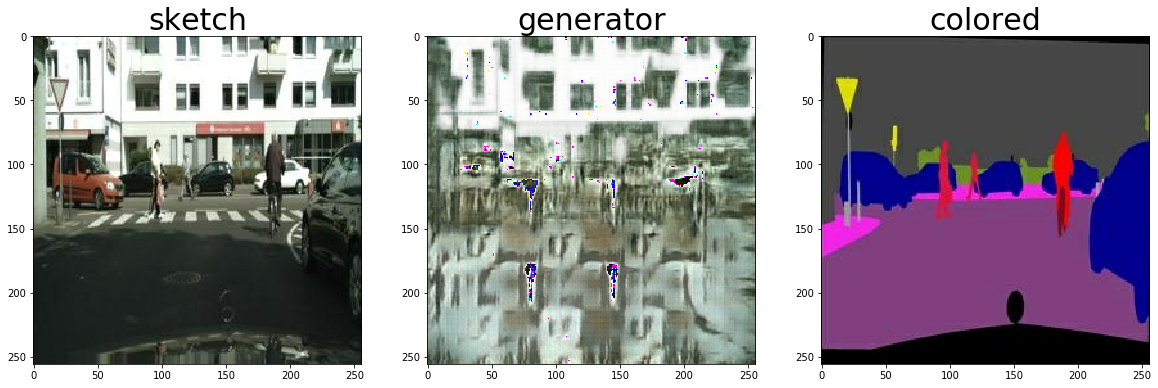

In [25]:
test_ind = 2

test_data_path = data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

f = test_data_path + os.listdir(test_data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch)) ; plt.title('sketch', fontsize = 30)
plt.subplot(1,3,2); plt.imshow(pred[0]) ; plt.title('generator', fontsize = 30)
plt.subplot(1,3,3); plt.imshow(denormalize(colored)); plt.title('colored', fontsize = 30)